In [88]:
import os
import sys
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage
from skimage.morphology import closing, ball, binary_dilation
from os.path import expanduser
import glob
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [89]:
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("SITK version:", sitk.__version__)
print("Scikit-image version:", skimage.__version__)

Python version: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
Numpy version: 1.26.2
Matplotlib version: 3.8.2
SITK version: 2.3.1
Scikit-image version: 0.22.0


### Loading Images

In [90]:
root_directory_to_dataset = '/mnt/data/datasets/RNSH_HFlung/TCIA CTVI/manifest-1661172139835/CT-vs-PET-Ventilation-Imaging'

In [91]:
# these are the notebook parameters when running from papermill
patient_id = 7
noninteract = False

In [92]:
Z_SLICE_BEFORE_RESAMPLE = 100
Z_SLICE_AFTER_RESAMPLE = 150

In [93]:
patient_dir = '{}/CT-PET-VI-{:02d}'.format(root_directory_to_dataset, patient_id)
path = '{}/*/*Galligas Lung*/*.dcm'.format(patient_dir)
file_l = sorted(glob.glob(path), key=lambda x: ( int(x.rsplit('/')[-1].split('.dcm')[0].replace('-',''))))

In [94]:
def load_patient_img(patient_id):
    patient_dir = '{}/CT-PET-VI-{:02d}'.format(root_directory_to_dataset, patient_id)
    print('Loading image data from: {}'.format(patient_dir))
    
    reader = sitk.ImageSeriesReader()

    # BH_EXP
    path = '{}/*/*Thorax Exp*/*.dcm'.format(patient_dir)
    file_l = sorted(glob.glob(path), key=lambda x: ( int(x.rsplit('/')[-1].split('.dcm')[0].replace('-',''))))
    print('{} BH exhale'.format(len(file_l)))
    reader.SetFileNames(file_l)
    image_exp = reader.Execute()
    
    # BH_INS
    path = '{}/*/*Thorax Ins*/*.dcm'.format(patient_dir)
    file_l = sorted(glob.glob(path), key=lambda x: ( int(x.rsplit('/')[-1].split('.dcm')[0].replace('-',''))))
    print('{} BH inhale'.format(len(file_l)))
    reader.SetFileNames(file_l)
    image_insp = reader.Execute()
    
    # for patient 5, remove the extra insp slices that don't have an exp slice
    if patient_id == 5:
        image_insp = image_insp[:,:,21:]

    # PETavg
    path = '{}/*/*Galligas Lung*/*.dcm'.format(patient_dir)
    file_l = sorted(glob.glob(path), key=lambda x: ( int(x.rsplit('/')[-1].split('.dcm')[0].replace('-',''))))
    print('{} PET'.format(len(file_l)))
    reader.SetFileNames(file_l)
    image_pet = reader.Execute()

    return image_exp, image_insp, image_pet

In [95]:
def array_to_image(arr, spacing, origin):
    im = sitk.GetImageFromArray(arr)
    im.SetSpacing(spacing)
    im.SetOrigin(origin)
    return im

In [96]:
exp_im, insp_im, pet_im = load_patient_img(patient_id)
exp_im_orig, insp_im_orig, _ = load_patient_img(patient_id)  # a hack; SITK doesn't have a method to copy an image?

Loading image data from: /mnt/data/datasets/RNSH_HFlung/TCIA CTVI/manifest-1661172139835/CT-vs-PET-Ventilation-Imaging/CT-PET-VI-07
167 BH exhale
167 BH inhale
159 PET
Loading image data from: /mnt/data/datasets/RNSH_HFlung/TCIA CTVI/manifest-1661172139835/CT-vs-PET-Ventilation-Imaging/CT-PET-VI-07
167 BH exhale
167 BH inhale
159 PET


In [97]:
# note that GetArrayFromImage returns a numpy array indexed as z,y,x
insp_arr = sitk.GetArrayFromImage(insp_im)
exp_arr = sitk.GetArrayFromImage(exp_im)
pet_arr = sitk.GetArrayFromImage(pet_im)

print("Inhalation max. value:", np.amax(insp_arr, (0, 1, 2)), 
      "\nInhalation min. value:", np.amin(insp_arr, (0, 1, 2)),
      "\nExhalation max. value:", np.amax(exp_arr, (0, 1, 2)),
      "\nExhalation min. value:", np.amin(exp_arr, (0, 1, 2)),
      "\nPET max. value:", int(np.amax(pet_arr)),
      "\nPET min. value:", np.amin(pet_arr),
      "\nUnique PET values:", len(np.unique(pet_arr)),
      "\nVoxels > 95 percentile of PET max.:", np.sum(pet_arr>(np.amax(pet_arr)*.95)))

Inhalation max. value: 3071 
Inhalation min. value: -1024 
Exhalation max. value: 3071 
Exhalation min. value: -1024 
PET max. value: 333485 
PET min. value: 0.0 
Unique PET values: 4391 
Voxels > 95 percentile of PET max.: 2


In [98]:
size_exp = exp_im.GetSize()
spacing_exp = exp_im.GetSpacing()
origin_exp = exp_im.GetOrigin()

print("Image size EXP:", str(size_exp[0]), str(size_exp[1]), str(size_exp[2]))
print("Spacing (mm):", str(spacing_exp[0]), str(spacing_exp[1]), str(spacing_exp[2]))
print("Origin (mm):", str(origin_exp[0]), str(origin_exp[1]), str(origin_exp[2]))

Image size EXP: 512 512 167
Spacing (mm): 0.9765625 0.9765625 1.7999999999999998
Origin (mm): -249.51171875 -422.51171875 -491.5


In [99]:
size_insp = insp_im.GetSize()
spacing_insp = insp_im.GetSpacing()
origin_insp = insp_im.GetOrigin()

print("Image size INSP:", str(size_insp[0]), str(size_insp[1]), str(size_insp[2]))
print("Spacing (mm):", str(spacing_insp[0]), str(spacing_insp[1]), str(spacing_insp[2]))
print("Origin (mm):", str(origin_insp[0]), str(origin_insp[1]), str(origin_insp[2]))

Image size INSP: 512 512 167
Spacing (mm): 0.9765625 0.9765625 1.7999999999999998
Origin (mm): -249.51171875 -422.51171875 -491.5


In [100]:
size_pet = pet_im.GetSize()
spacing_pet = pet_im.GetSpacing()
origin_pet = pet_im.GetOrigin()

print("Image size PET:", str(size_pet[0]), str(size_pet[1]), str(size_pet[2]))
print("Spacing (mm):", str(spacing_pet[0]), str(spacing_pet[1]), str(spacing_pet[2]))
print("Origin (mm):", str(origin_pet[0]), str(origin_pet[1]), str(origin_pet[2]))

Image size PET: 400 400 159
Spacing (mm): 2.03642 2.03642 2.2
Origin (mm): -406.949 -579.581 -463.5


### Masking and cropping the BHCT

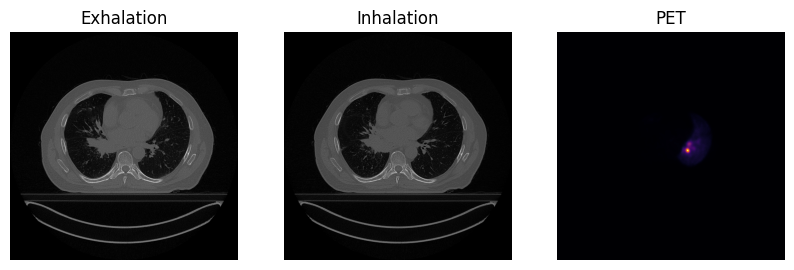

In [101]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,10))
ax1.imshow(exp_arr[Z_SLICE_BEFORE_RESAMPLE], cmap="gray")
ax1.set_title('Exhalation')
ax1.set_axis_off()

ax2.imshow(insp_arr[Z_SLICE_BEFORE_RESAMPLE], cmap="gray")
ax2.set_title('Inhalation')
ax2.set_axis_off()

ax3.imshow(pet_arr[Z_SLICE_BEFORE_RESAMPLE], cmap="inferno")
ax3.set_title('PET')
ax3.set_axis_off()

In [102]:
# Applying a threshold equivalent to -500HU. 

exp_mask_arr = exp_arr < -500
insp_mask_arr = insp_arr < -500

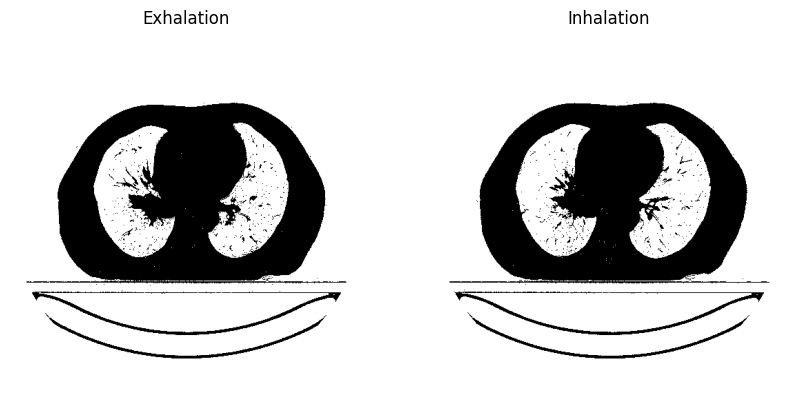

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(exp_mask_arr[Z_SLICE_BEFORE_RESAMPLE], cmap="gray")
ax1.set_title('Exhalation')
ax1.set_axis_off()

ax2.imshow(insp_mask_arr[Z_SLICE_BEFORE_RESAMPLE], cmap="gray")
ax2.set_title('Inhalation')
ax2.set_axis_off()

In [104]:
# Setting the neighbourhood to be a pixel array.
closing_footprint = ball(2)

exp_mask_arr = closing(exp_mask_arr, closing_footprint)
insp_mask_arr = closing(insp_mask_arr, closing_footprint)

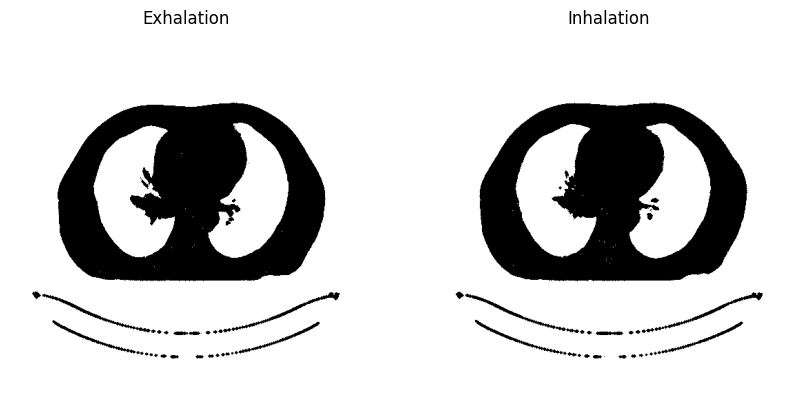

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(exp_mask_arr[Z_SLICE_BEFORE_RESAMPLE], cmap="gray")
ax1.set_title('Exhalation')
ax1.set_axis_off()

ax2.imshow(insp_mask_arr[Z_SLICE_BEFORE_RESAMPLE], cmap="gray")
ax2.set_title('Inhalation')
ax2.set_axis_off()

In [106]:
dilation_footprint = ball(1)

exp_mask_arr = binary_dilation(exp_mask_arr, dilation_footprint)
insp_mask_arr = binary_dilation(insp_mask_arr, dilation_footprint)

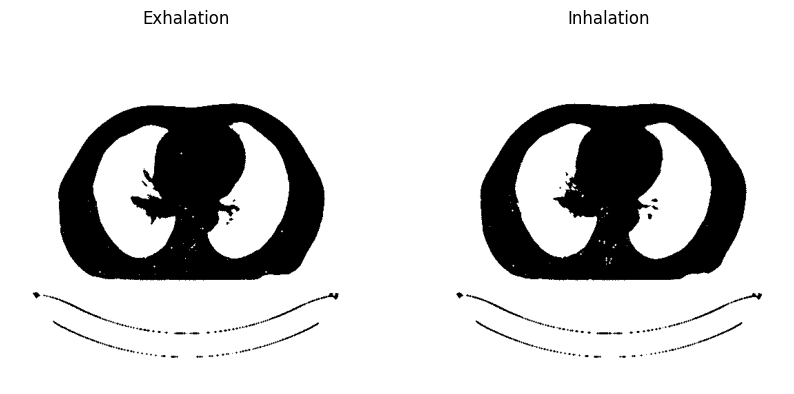

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(exp_mask_arr[Z_SLICE_BEFORE_RESAMPLE], cmap="gray")
ax1.set_title('Exhalation')
ax1.set_axis_off()

ax2.imshow(insp_mask_arr[Z_SLICE_BEFORE_RESAMPLE], cmap="gray")
ax2.set_title('Inhalation')
ax2.set_axis_off()

In [108]:
# Filling in the outside region.
from skimage.segmentation import flood_fill

exp_mask_arr = flood_fill(exp_mask_arr, (0,0,0), False)
insp_mask_arr = flood_fill(insp_mask_arr, (0,0,0), False)

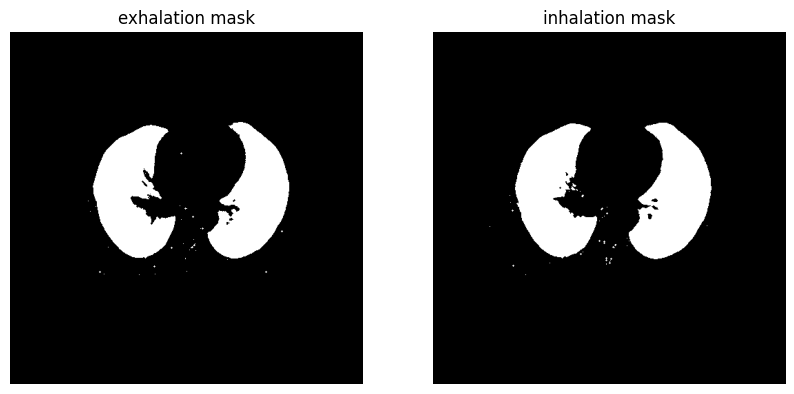

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(exp_mask_arr[Z_SLICE_BEFORE_RESAMPLE], cmap="gray")
ax1.set_title('exhalation mask')
ax1.set_axis_off()

ax2.imshow(insp_mask_arr[Z_SLICE_BEFORE_RESAMPLE], cmap="gray")
ax2.set_title('inhalation mask')
ax2.set_axis_off()

#### apply the mask to the BHCT images

In [110]:
exp_arr[~exp_mask_arr] = np.min(exp_arr)
insp_arr[~insp_mask_arr] = np.min(insp_arr)

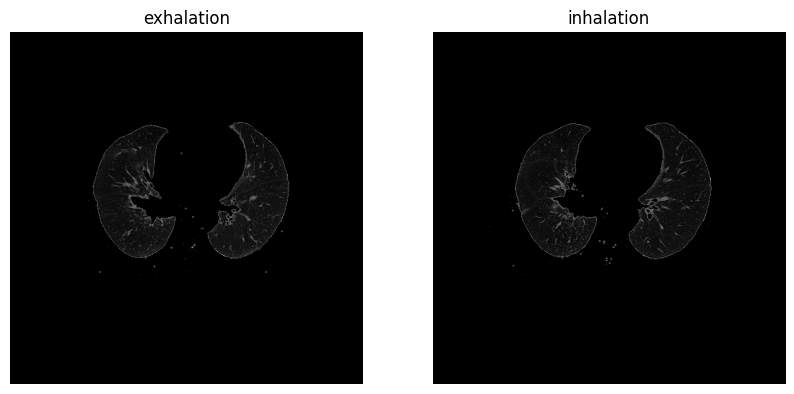

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(exp_arr[Z_SLICE_BEFORE_RESAMPLE], cmap="gray")
ax1.set_title('exhalation')
ax1.set_axis_off()

ax2.imshow(insp_arr[Z_SLICE_BEFORE_RESAMPLE], cmap="gray")
ax2.set_title('inhalation')
ax2.set_axis_off()

#### create the union mask

In [112]:
mask_arr = np.logical_or(exp_mask_arr, insp_mask_arr)

### Saving CT images in Hounsfields Units and mask as MHA

In [113]:
exp_im = array_to_image(exp_arr, spacing=spacing_exp, origin=origin_exp)
insp_im = array_to_image(insp_arr, spacing=spacing_insp, origin=origin_insp)
mask_im = array_to_image(mask_arr.astype(np.float32), spacing=spacing_exp, origin=origin_exp)

In [114]:
print(exp_im.GetSize(), exp_im.GetSpacing(), exp_im.GetOrigin())
print(insp_im.GetSize(), insp_im.GetSpacing(), insp_im.GetOrigin())
print(mask_im.GetSize(), mask_im.GetSpacing(), mask_im.GetOrigin())

(512, 512, 167) (0.9765625, 0.9765625, 1.7999999999999998) (-249.51171875, -422.51171875, -491.5)
(512, 512, 167) (0.9765625, 0.9765625, 1.7999999999999998) (-249.51171875, -422.51171875, -491.5)
(512, 512, 167) (0.9765625, 0.9765625, 1.7999999999999998) (-249.51171875, -422.51171875, -491.5)


In [115]:
# exp_im and insp_im are images in HU floats
# mask_im is an image of 0 and 1 in float32 format

In [116]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'

In [117]:
PREPROCESSED_MHA_DIR = '{}/mha/Patient{:02d}'.format(PREPROCESSED_BASE_DIR, patient_id)
if not os.path.exists(PREPROCESSED_MHA_DIR):
    os.makedirs(PREPROCESSED_MHA_DIR)

output_name = '{}/phase-inhale-nomask.mha'.format(PREPROCESSED_MHA_DIR)
sitk.WriteImage(insp_im_orig, output_name)
print('save to {}'.format(output_name))

output_name = '{}/phase-exhale-nomask.mha'.format(PREPROCESSED_MHA_DIR)
sitk.WriteImage(exp_im_orig, output_name)
print('save to {}'.format(output_name))

output_name = '{}/mask-union.mha'.format(PREPROCESSED_MHA_DIR)
sitk.WriteImage(mask_im, output_name)
print('save to {}'.format(output_name))

save to /mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch/mha/Patient07/phase-inhale-nomask.mha
save to /mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch/mha/Patient07/phase-exhale-nomask.mha
save to /mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch/mha/Patient07/mask-union.mha


#### Resample the images to (1mm, 1mm, 1mm)

In [118]:
# make sure all the images are floats but keep the mask as boolean
pet_im = sitk.Cast(sitk.RescaleIntensity(pet_im), sitk.sitkFloat32)
exp_im = sitk.Cast(sitk.RescaleIntensity(exp_im), sitk.sitkFloat32)
insp_im = sitk.Cast(sitk.RescaleIntensity(insp_im), sitk.sitkFloat32)

In [119]:
# Resampling the images into (1,1,1)mm voxel size. Can use nearest neighbour for interpolation (default is B-spline). 
def resample_image(itk_image, out_spacing=(1.0, 1.0, 1.0), is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [120]:
print('before resampling:')
print('PET spacing: {}, size: {}'.format(pet_im.GetSpacing(), pet_im.GetSize()))
print('BHCT spacing: {}, size: {}'.format(exp_im.GetSpacing(), exp_im.GetSize()))

before resampling:
PET spacing: (2.03642, 2.03642, 2.2), size: (400, 400, 159)
BHCT spacing: (0.9765625, 0.9765625, 1.7999999999999998), size: (512, 512, 167)


In [121]:
pet_im = resample_image(pet_im)
exp_im = resample_image(exp_im)
insp_im = resample_image(insp_im)
mask_im = resample_image(mask_im)

In [122]:
print('after resampling:')
pet_spacing = pet_im.GetSpacing()
pet_size = pet_im.GetSize()
pet_origin = pet_im.GetOrigin()

ct_spacing = exp_im.GetSpacing()
ct_size = exp_im.GetSize()
ct_origin = exp_im.GetOrigin()

print('PET spacing: {}, size: {}, origin: {}'.format(pet_spacing, pet_size, pet_origin))
print('BHCT spacing: {}, size: {}, origin: {}'.format(ct_spacing, ct_size, ct_origin))

after resampling:
PET spacing: (1.0, 1.0, 1.0), size: (815, 815, 350), origin: (-406.949, -579.581, -463.5)
BHCT spacing: (1.0, 1.0, 1.0), size: (500, 500, 301), origin: (-249.51171875, -422.51171875, -491.5)


In [123]:
# convert back into numpy array after resampling
pet_arr = sitk.GetArrayFromImage(pet_im)
exp_arr = sitk.GetArrayFromImage(exp_im)
insp_arr = sitk.GetArrayFromImage(insp_im)
mask_arr = sitk.GetArrayFromImage(mask_im)

#### re-quantise the mask after resampling

In [124]:
np.min(mask_arr), np.max(mask_arr)

(-0.46053714, 8.0)

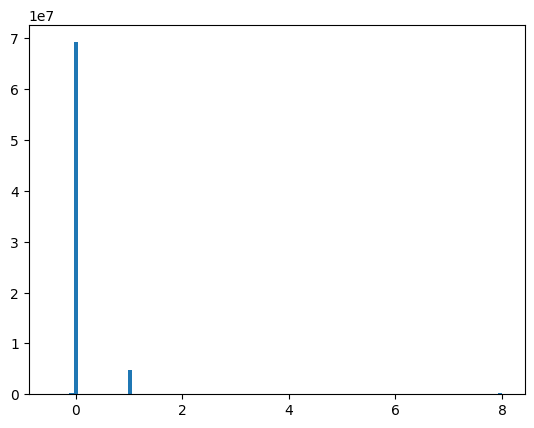

In [125]:
arr = mask_arr.ravel()
_ = plt.hist(arr, bins=100)

In [126]:
mask_arr = mask_arr > 0.5

### crop the images to remove empty space and save memory

In [127]:
pet_arr.shape, exp_arr.shape, insp_arr.shape, mask_arr.shape

((350, 815, 815), (301, 500, 500), (301, 500, 500), (301, 500, 500))

In [128]:
TARGET_SIZE_X = 320
TARGET_SIZE_Y = 320
TARGET_SIZE_Z = 300

In [129]:
# discard CT slices (z-axis) at the back if we don't have matching PET slices
if pet_arr.shape[0] < exp_arr.shape[0]:
    crop_z_upper = pet_arr.shape[0]
    exp_arr = exp_arr[:crop_z_upper, :, :]
    insp_arr = insp_arr[:crop_z_upper, :, :]
    mask_arr = mask_arr[:crop_z_upper, :, :]
    print('trimmed CT and mask to {} slices to match PET'.format(crop_z_upper))

# discard PET slices (z-axis) at the back if we don't have matching CT slices
if pet_arr.shape[0] > exp_arr.shape[0]:
    crop_z_upper = exp_arr.shape[0]
    pet_arr = pet_arr[:crop_z_upper, :, :]
    print('trimmed PET to {} slices to match CT'.format(crop_z_upper))

# pad CT z axis to the target size, if needed
if exp_arr.shape[0] < TARGET_SIZE_Z:
    pad_slices = TARGET_SIZE_Z - exp_arr.shape[0]
    exp_arr = np.pad(exp_arr, pad_width=((0,pad_slices),(0,0),(0,0)), mode='constant', constant_values=np.min(exp_arr))  # pad at the back
    insp_arr = np.pad(insp_arr, pad_width=((0,pad_slices),(0,0),(0,0)), mode='constant', constant_values=np.min(insp_arr))  # pad at the back
    mask_arr = np.pad(mask_arr, pad_width=((0,pad_slices),(0,0),(0,0)), mode='constant', constant_values=np.min(mask_arr))  # pad at the back
    print('padded CT and mask with {} slices to match target'.format(pad_slices))

# pad PET z axis to the target size, if needed
if pet_arr.shape[0] < TARGET_SIZE_Z:
    pad_slices = TARGET_SIZE_Z - pet_arr.shape[0]
    pet_arr = np.pad(pet_arr, pad_width=((0,pad_slices),(0,0),(0,0)), mode='constant', constant_values=np.min(pet_arr))  # pad at the back
    print('padded PET with {} slices to match target'.format(pad_slices))

# crop x and y axes of CT to the target size
crop_x_lower = int(np.round((exp_arr.shape[2]-TARGET_SIZE_X)/2)); crop_x_upper = crop_x_lower+TARGET_SIZE_X
crop_y_lower = int(np.round((exp_arr.shape[1]-TARGET_SIZE_Y)/2)); crop_y_upper = crop_y_lower+TARGET_SIZE_Y
crop_z_lower = int(np.round((exp_arr.shape[0]-TARGET_SIZE_Z)/2)); crop_z_upper = crop_z_lower+TARGET_SIZE_Z

exp_arr = exp_arr[crop_z_lower:crop_z_upper, crop_y_lower:crop_y_upper, crop_x_lower:crop_x_upper]
insp_arr = insp_arr[crop_z_lower:crop_z_upper, crop_y_lower:crop_y_upper, crop_x_lower:crop_x_upper]
mask_arr = mask_arr[crop_z_lower:crop_z_upper, crop_y_lower:crop_y_upper, crop_x_lower:crop_x_upper]

# crop x and y axes of PET to the target size
crop_x_lower = int(np.round((pet_arr.shape[2]-TARGET_SIZE_X)/2)); crop_x_upper = crop_x_lower+TARGET_SIZE_X
crop_y_lower = int(np.round((pet_arr.shape[1]-TARGET_SIZE_Y)/2)); crop_y_upper = crop_y_lower+TARGET_SIZE_Y
crop_z_lower = int(np.round((pet_arr.shape[0]-TARGET_SIZE_Z)/2)); crop_z_upper = crop_z_lower+TARGET_SIZE_Z

pet_arr = pet_arr[crop_z_lower:crop_z_upper, crop_y_lower:crop_y_upper, crop_x_lower:crop_x_upper]

exp_arr.shape, insp_arr.shape, mask_arr.shape, pet_arr.shape

trimmed PET to 301 slices to match CT


((300, 320, 320), (300, 320, 320), (300, 320, 320), (300, 320, 320))

In [130]:
dimensions_d = {'exp_arr':exp_arr.shape, 'insp_arr':insp_arr.shape, 'mask_arr':mask_arr.shape, 'pet_arr':pet_arr.shape}

In [131]:
METADATA_FILE = '{}/metadata.pkl'.format(PREPROCESSED_BASE_DIR)

if os.path.isfile(METADATA_FILE):
    with open(METADATA_FILE, 'rb') as f:
        metadata_d = pickle.load(f)
else:
    metadata_d = {}

metadata_d[patient_id] = dimensions_d

with open(METADATA_FILE, 'wb') as f:
        pickle.dump(metadata_d, f)

In [132]:
metadata_d

{2: {'exp_arr': (300, 320, 320),
  'insp_arr': (300, 320, 320),
  'mask_arr': (300, 320, 320),
  'pet_arr': (300, 320, 320)},
 1: {'exp_arr': (300, 320, 320),
  'insp_arr': (300, 320, 320),
  'mask_arr': (300, 320, 320),
  'pet_arr': (300, 320, 320)},
 3: {'exp_arr': (300, 320, 320),
  'insp_arr': (300, 320, 320),
  'mask_arr': (300, 320, 320),
  'pet_arr': (300, 320, 320)},
 4: {'exp_arr': (300, 320, 320),
  'insp_arr': (300, 320, 320),
  'mask_arr': (300, 320, 320),
  'pet_arr': (300, 320, 320)},
 5: {'exp_arr': (300, 320, 320),
  'insp_arr': (300, 320, 320),
  'mask_arr': (300, 320, 320),
  'pet_arr': (300, 320, 320)},
 6: {'exp_arr': (300, 320, 320),
  'insp_arr': (300, 320, 320),
  'mask_arr': (300, 320, 320),
  'pet_arr': (300, 320, 320)},
 7: {'exp_arr': (300, 320, 320),
  'insp_arr': (300, 320, 320),
  'mask_arr': (300, 320, 320),
  'pet_arr': (300, 320, 320)},
 8: {'exp_arr': (300, 320, 320),
  'insp_arr': (300, 320, 320),
  'mask_arr': (300, 320, 320),
  'pet_arr': (300, 320,

In [133]:
if not ((exp_arr.shape == (TARGET_SIZE_Z, TARGET_SIZE_Y, TARGET_SIZE_X)) and 
        (insp_arr.shape == (TARGET_SIZE_Z, TARGET_SIZE_Y, TARGET_SIZE_X)) and 
        (pet_arr.shape == (TARGET_SIZE_Z, TARGET_SIZE_Y, TARGET_SIZE_X)) and
        (mask_arr.shape == (TARGET_SIZE_Z, TARGET_SIZE_Y, TARGET_SIZE_X))):
    assert False
else:
    print('all dimensions match')

all dimensions match


In [134]:
exp_im = array_to_image(exp_arr, spacing=ct_spacing, origin=ct_origin)
insp_im = array_to_image(insp_arr, spacing=ct_spacing, origin=ct_origin)
mask_im = array_to_image(mask_arr.astype(np.float32), spacing=ct_spacing, origin=ct_origin)
pet_im = array_to_image(pet_arr, spacing=pet_spacing, origin=pet_origin)

### rigid registration of the PET with the BHCT

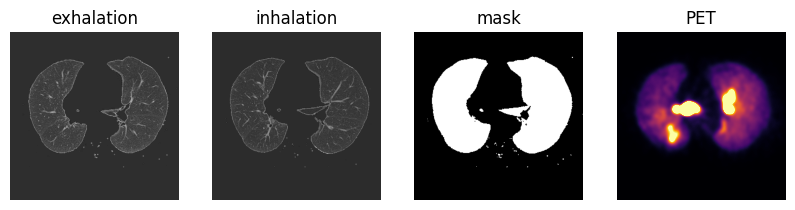

In [135]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))
ax1.imshow(exp_arr[Z_SLICE_AFTER_RESAMPLE], cmap="gray")
ax1.set_title('exhalation')
ax1.set_axis_off()

ax2.imshow(insp_arr[Z_SLICE_AFTER_RESAMPLE], cmap="gray")
ax2.set_title('inhalation')
ax2.set_axis_off()

ax3.imshow(mask_arr[Z_SLICE_AFTER_RESAMPLE], cmap="gray")
ax3.set_title('mask')
ax3.set_axis_off()

vmin = np.percentile(pet_arr[Z_SLICE_AFTER_RESAMPLE],10)
vmax = np.percentile(pet_arr[Z_SLICE_AFTER_RESAMPLE],98)
ax4.imshow(pet_arr[Z_SLICE_AFTER_RESAMPLE], cmap="inferno", vmin=vmin, vmax=vmax)
ax4.set_title('PET')
ax4.set_axis_off()

### automated rigid registration
source: http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html

In [136]:
from ipywidgets import interact, fixed
from IPython.display import clear_output

In [137]:
# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [138]:
fixed_image = exp_im
moving_image = pet_im

if not noninteract:
    interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=149, description='fixed_image_z', max=299), IntSlider(value=149, descrip…

In [139]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

if not noninteract:
    interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=149, description='image_z', max=299), FloatSlider(value=0.5, description…

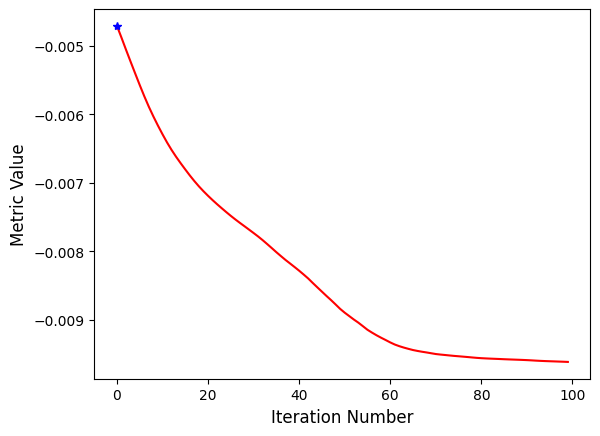

In [140]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.10)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
# registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
# registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
# registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                               sitk.Cast(moving_image, sitk.sitkFloat32))

In [141]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.009617476380896101
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.


In [142]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

if not noninteract:
    interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=149, description='image_z', max=299), FloatSlider(value=0.5, description…

In [143]:
PREPROCESSED_SHAPING_DIR = '{}/shaping'.format(PREPROCESSED_BASE_DIR)

if not os.path.exists(PREPROCESSED_SHAPING_DIR):
    os.makedirs(PREPROCESSED_SHAPING_DIR)

In [144]:
pet_im = moving_resampled

# save the transform
SHAPING_FILE = '{}/Patient{:02d}.tfm'.format(PREPROCESSED_SHAPING_DIR, patient_id)
sitk.WriteTransform(final_transform, SHAPING_FILE)

In [145]:
pet_arr = sitk.GetArrayFromImage(pet_im)

In [146]:
pet_arr.shape, exp_arr.shape

((300, 320, 320), (300, 320, 320))

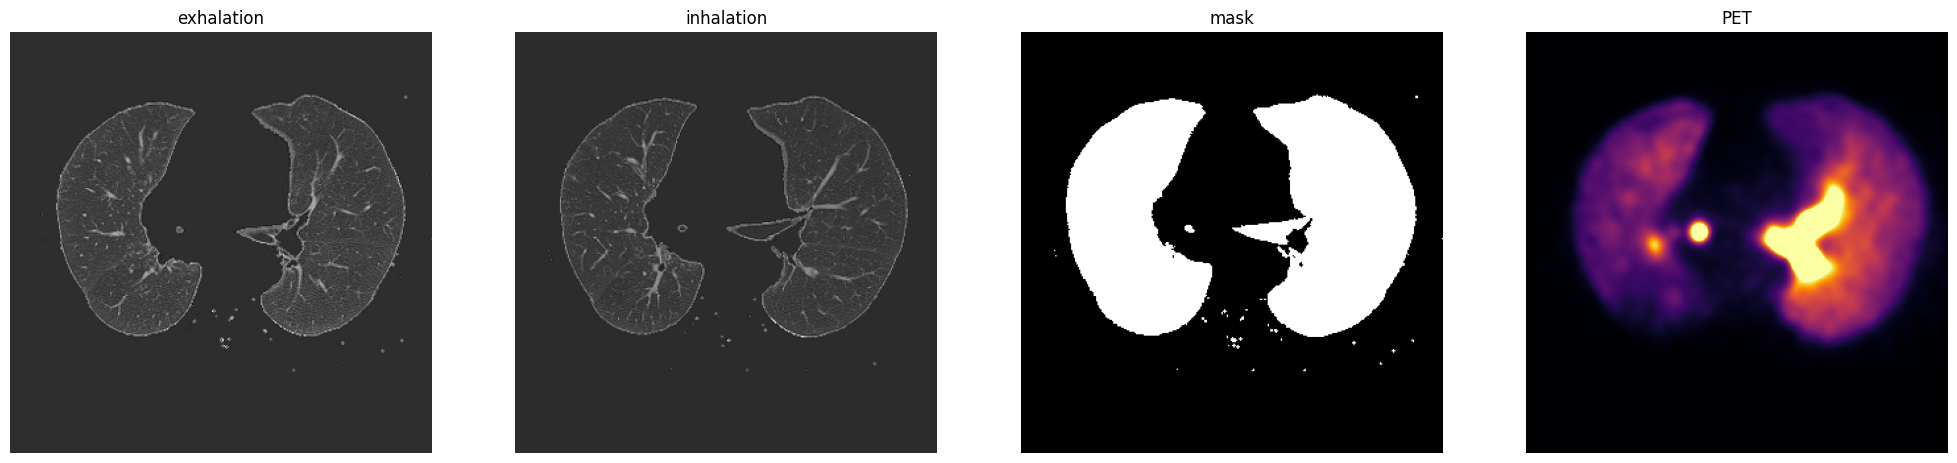

In [147]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,25))
ax1.imshow(exp_arr[Z_SLICE_AFTER_RESAMPLE], cmap="gray")
ax1.set_title('exhalation')
ax1.set_axis_off()

ax2.imshow(insp_arr[Z_SLICE_AFTER_RESAMPLE], cmap="gray")
ax2.set_title('inhalation')
ax2.set_axis_off()

ax3.imshow(mask_arr[Z_SLICE_AFTER_RESAMPLE], cmap="gray")
ax3.set_title('mask')
ax3.set_axis_off()

vmin = np.percentile(pet_arr[Z_SLICE_AFTER_RESAMPLE],10)
vmax = np.percentile(pet_arr[Z_SLICE_AFTER_RESAMPLE],98)
ax4.imshow(pet_arr[Z_SLICE_AFTER_RESAMPLE], vmin=vmin, vmax=vmax, cmap="inferno")
ax4.set_title('PET')
ax4.set_axis_off()

### apply the mask to the PET image

In [148]:
pet_arr[~mask_arr] = np.min(pet_arr)

### Standardising

In [149]:
np.min(pet_arr), np.max(pet_arr)

(-0.0038462358, 239.32556)

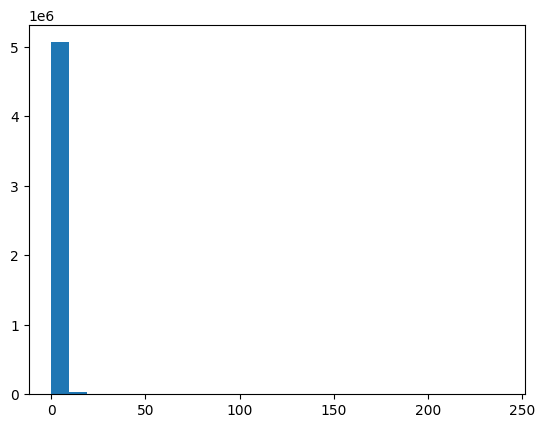

In [150]:
# Histogram before standardisation.
pf = pet_arr[pet_arr>0]
_ = plt.hist(pf.ravel(), bins=25)

In [151]:
# Any voxels greater than patient mean + 4*patient std_dev is set equal to 1.

def standardised(pet_arr):
    pt_mean = np.mean(pet_arr[pet_arr>0])
    pt_std = np.std(pet_arr[pet_arr>0])
    pt_more = pet_arr>(pt_mean+4*pt_std)
    pet_arr[pt_more] = (pt_mean+4*pt_std)
    print("Mean Galligas PET value:", pt_mean)
    print("Standard deviation of Galligas PET values:",pt_std)
    print("Number of reassigned voxels:", np.sum(pt_more))
    return pet_arr

In [152]:
pet_arr = standardised(pet_arr)

Mean Galligas PET value: 1.2243842
Standard deviation of Galligas PET values: 2.7702599
Number of reassigned voxels: 29179


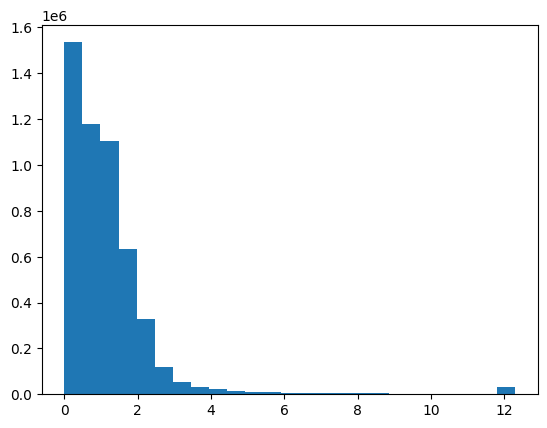

In [153]:
# Histogram after standardisation
pf = pet_arr[pet_arr>0]
_ = plt.hist(pf.ravel(), bins=25)

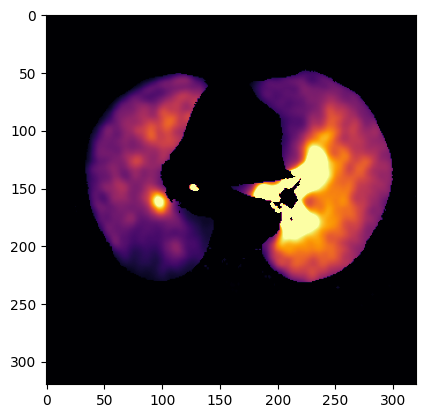

In [154]:
vmin = np.percentile(pet_arr[Z_SLICE_AFTER_RESAMPLE],10)
vmax = np.percentile(pet_arr[Z_SLICE_AFTER_RESAMPLE],98)
_ = plt.imshow(pet_arr[Z_SLICE_AFTER_RESAMPLE][:, :], cmap='inferno', vmin=vmin, vmax=vmax)

### normalise all masked images

In [155]:
# Normalising the PET
from skimage import exposure

NORMALISED_MIN = 1e-3
exp_arr = exposure.rescale_intensity(exp_arr, in_range='image', out_range=(NORMALISED_MIN, 1.))
insp_arr = exposure.rescale_intensity(insp_arr, in_range='image', out_range=(NORMALISED_MIN, 1.))
pet_arr = exposure.rescale_intensity(pet_arr, in_range='image', out_range=(NORMALISED_MIN, 1.))

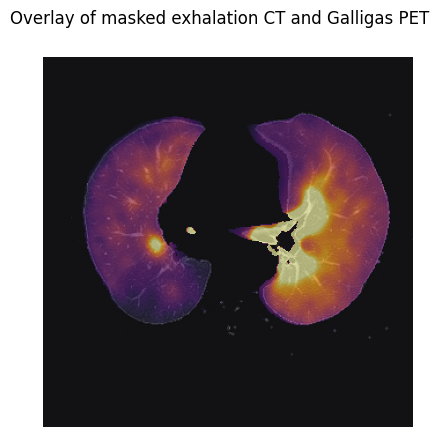

In [156]:
plt.imshow(exp_arr[Z_SLICE_AFTER_RESAMPLE], cmap="gray")
vmin = np.percentile(pet_arr[Z_SLICE_AFTER_RESAMPLE],10)
vmax = np.percentile(pet_arr[Z_SLICE_AFTER_RESAMPLE],98)
plt.imshow(pet_arr[Z_SLICE_AFTER_RESAMPLE], cmap="inferno", alpha=0.6, vmin=vmin, vmax=vmax)
plt.axis("off")
plt.suptitle("Overlay of masked exhalation CT and Galligas PET")
plt.show()

#### segment the PET image based on percentiles

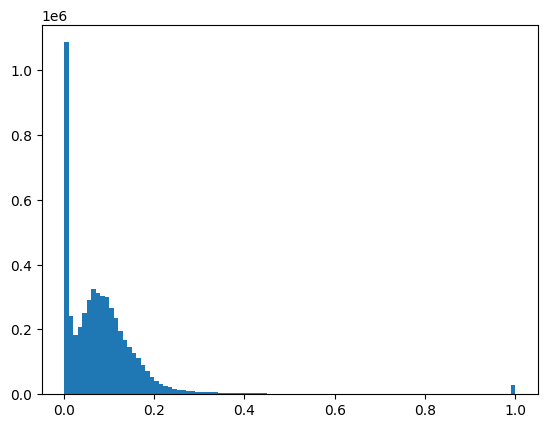

In [157]:
arr = pet_arr[mask_arr].ravel()
_ = plt.hist(arr, bins=100)

In [158]:
np.median(arr)

0.07313696

In [159]:
# calculate the 30th and 70th percentiles of the masked PET
percentile_high = np.percentile(arr,70)
percentile_medium = np.percentile(arr,30)
percentile_high, percentile_medium

(0.10887959450483319, 0.03511095494031906)

In [160]:
# we label voxels above the 70th percentile as 'high', between the 30th and 70th as 'medium', below the 30th as 'low', and outside the 
# mask as 'background'
pet_label_high_arr = np.where((mask_arr==True) & (pet_arr>percentile_high), 1 , 0)
pet_label_medium_arr = np.where((mask_arr==True) & (pet_arr<=percentile_high) & (pet_arr>=percentile_medium), 2 , 0)
pet_label_low_arr = np.where((mask_arr==True) & (pet_arr<percentile_medium), 3 , 0)

In [161]:
pet_label_arr = pet_label_high_arr + pet_label_medium_arr + pet_label_low_arr

In [162]:
label_names = {0:'background', 1:'high', 2:'medium', 3:'low'}

In [163]:
np.unique(pet_label_arr)

array([0, 1, 2, 3])

#### display the results

In [164]:
import matplotlib.patches as mpatches

In [165]:
labels_d = {0:'background', 1:'high', 2:'medium', 3:'low'}

# set up the colour map
colours_d = {
    0: 'black',
    1: 'lime',
    2: 'lightseagreen',
    3: 'slategray'
}

cm = ListedColormap(colours_d.values())

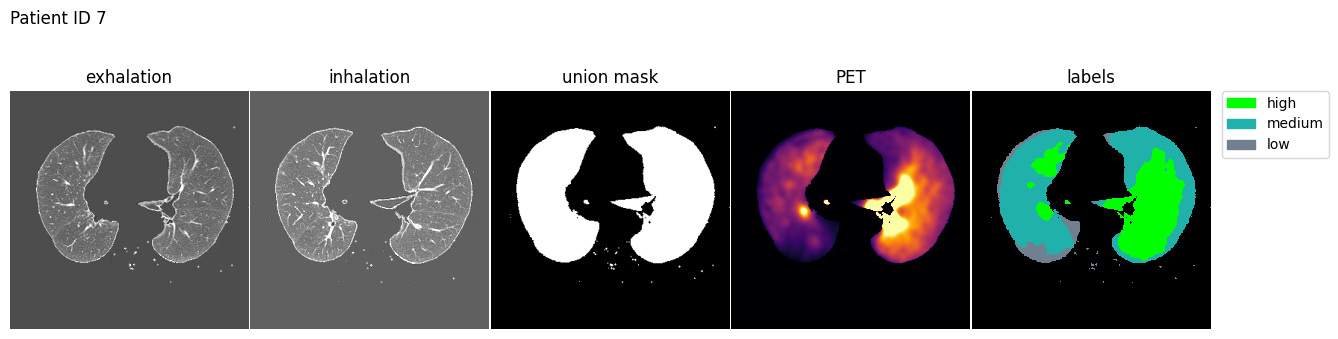

In [166]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15,4))
ax1.imshow(exp_arr[Z_SLICE_AFTER_RESAMPLE], vmax=0.4, cmap="gray")
ax1.set_title('exhalation')
ax1.set_axis_off()

ax2.imshow(insp_arr[Z_SLICE_AFTER_RESAMPLE], vmax=0.4, cmap="gray")
ax2.set_title('inhalation')
ax2.set_axis_off()

ax3.imshow(mask_arr[Z_SLICE_AFTER_RESAMPLE], cmap="gray")
ax3.set_title('union mask')
ax3.set_axis_off()

vmin = np.percentile(pet_arr[Z_SLICE_AFTER_RESAMPLE],10)
vmax = np.percentile(pet_arr[Z_SLICE_AFTER_RESAMPLE],98)
ax4.imshow(pet_arr[Z_SLICE_AFTER_RESAMPLE], cmap='inferno', vmin=vmin, vmax=vmax)
ax4.set_title('PET')
ax4.set_axis_off()

im = ax5.imshow(pet_label_arr[Z_SLICE_AFTER_RESAMPLE], cmap=cm, interpolation='none')
ax5.set_title('labels')
ax5.set_axis_off()

# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colours_d[i], label="{l}".format(l=labels_d[i]) ) for i in [1,2,3] ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

fig.suptitle('Patient ID {}'.format(patient_id), x=0.1, y=1.0, fontsize=12, ha='left')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

In [167]:
def format_fn(tick_val, tick_pos):
    result = ''
    if int(tick_val) in label_names.keys():
        result = label_names[int(tick_val)]
    else:
        result = ''
    return result

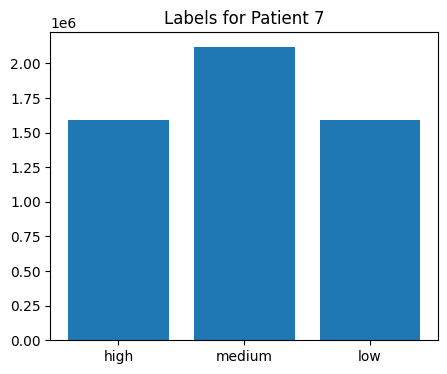

In [168]:
u,c = np.unique(pet_label_arr.astype(int), return_counts=True)

fig, ax = plt.subplots(figsize=(5,4))
_ = ax.bar(u[1:],c[1:])
ax.xaxis.set_major_formatter(format_fn)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
_ = ax.set_title('Labels for Patient {}'.format(patient_id))

### Saving numpy arrays as stack

In [169]:
# insp_mask_arr is a 3D array of booleans; background is False
# exp_arr and insp_arr are arrays of floats in HU
# pet_arr is an array of floats in normalised intensity
# pet_label_arr is an array of voxel labels

In [170]:
pt_arr = np.array([exp_arr, insp_arr, pet_arr, pet_label_arr, mask_arr.astype(int)])
pt_arr.shape  # note the shape is 5,z,y,x

(5, 300, 320, 320)

In [171]:
PREPROCESSED_STACK_DIR = '{}/stack'.format(PREPROCESSED_BASE_DIR)
if not os.path.exists(PREPROCESSED_STACK_DIR):
    os.makedirs(PREPROCESSED_STACK_DIR)

output_name = '{}/Patient{:02d}.npy'.format(PREPROCESSED_STACK_DIR, patient_id)
np.save(output_name, pt_arr)
print('save to {}'.format(output_name))

save to /mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch/stack/Patient07.npy
